---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

In [8]:
# create more cells if necessary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchvision import datasets, transforms, models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [6]:
# create more cells if necessary
# Load data
file_path = "assignment3-ner_dataset.txt"

# Read the file line by line
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines() 

# Parse lines into sentences
sentences = []
sentence = []

for line in lines:
    line = line.strip()
    if line == "": # End of a sentence
        if sentence:
            sentences.append(sentence)
            sentence = []
    else:
        word, tag = line.split()
        sentence.append((word, tag))

# Append the last sentence
if sentence:
    sentences.append(sentence)

In [9]:
def has_entity(sentence):
    """
    Check whether the given sentence contains any named entity.

    Args:
        sentence (list of tuples): A sentence represented as a list of (word, tag) pairs.

    Returns:
        int: 1 if the sentence contains at least one tag that is not "O", otherwise 0.
    """
    return int(any(tag != 'O' for _, tag in sentence))

# Create a label list indicating whether each contains any named entity
stratify_labels = [has_entity(s) for s in sentences]

# First split: train vs temp (with stratification to preserve entity distribution)
train_sentences, temp_sentences, = train_test_split(
    sentences, test_size=0.3, random_state=42, stratify=stratify_labels)

# Second split: temp -> validation and test (also stratified)
val_labels = [has_entity(s) for s in temp_sentences]
val_sentences, test_sentences = train_test_split(
    temp_sentences, test_size=0.5, random_state=42, stratify=val_labels)

# Print dataset size for each splilt
print(f"Train: {len(train_sentences)}, Validation: {len(val_sentences)}, Test: {len(test_sentences)}")

Train: 1187, Validation: 254, Test: 255


In [10]:
# Create tag index mappings (tag2idx and idx2tag)

# Collect all unique NER tags from the training set
unique_tags = set()
for sentence in train_sentences:
    for _, tag in sentence:
        unique_tags.add(tag)

# Sort tags for consistent indexing
tag_list = sorted(list(unique_tags))

# Create mappings: tag -> index and index -> tag
tag2idx = {tag: idx for idx, tag in enumerate(tag_list)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

# Display tag vocabulary size and example mapping
print("Total number of unique tags:", len(tag_list))
print("Tag to index mapping:", tag2idx)

Total number of unique tags: 5
Tag to index mapping: {'I-LOC': 0, 'I-MISC': 1, 'I-ORG': 2, 'I-PER': 3, 'O': 4}


In [11]:
# Create word index mappings (word2idx and idx2word)

# Collect all unique words from the training set
unique_words = set()
for sentence in train_sentences:
    for word, _ in sentence:
        unique_words.add(word)

# Add special tokens for padding and unknown words
special_tokens = ["<PAD>", "<UNK>"]
unique_words.update(special_tokens)

# Sort the vocabulary for consistent indexing
word_list = sorted(list(unique_words))

# Create mappings: word -> index and index -> word
word2idx = {word: idx for idx, word in enumerate(sorted(unique_words))}
idx2word = {idx: word for word, idx in word2idx.items()}

# Display vocabulary size and a sample of the mapping
print("Total number of unique words:", len(word_list))
print("Example word to index mapping:", dict(list(word2idx.items())[:10]))

Total number of unique words: 6845
Example word to index mapping: {'!': 0, '"': 1, '#': 2, '$0.35': 3, '$1': 4, '$120,000': 5, '$175': 6, '$2': 7, '$2.1': 8, '$2.10': 9}


In [13]:
# Print the index values for special tokens: <PAD> and <UNK>
print(word2idx["<PAD>"], word2idx["<UNK>"])

390 391


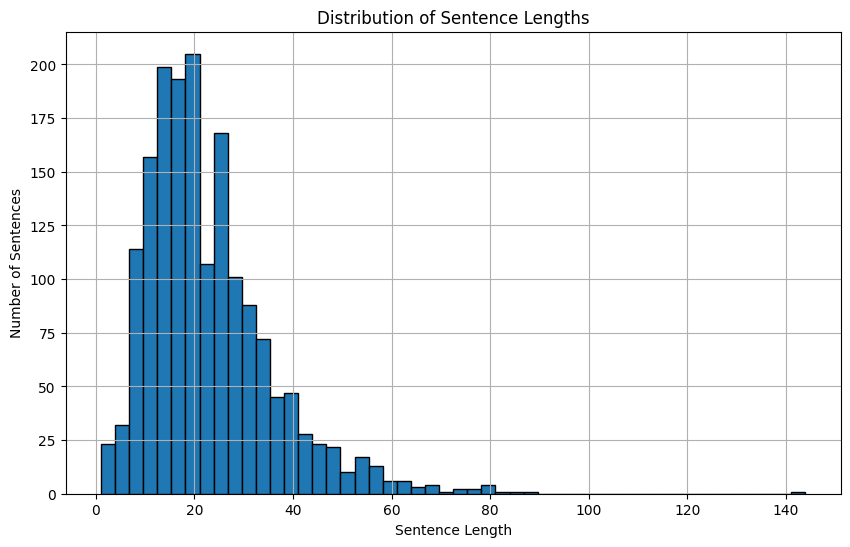

In [14]:

# Calculate the length (number of tokens) for each sentence
sentence_lengths = [len(sentence) for sentence in sentences]

# Plot a histogram to visualize the distribution of sentence length
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences")
plt.grid(True)
plt.show()

In [114]:
class NERDataset(Dataset):
    """
    Custom Dataset for Named Entity Recognition (NER).
    Each item is a sentence encoded as a sequence of word and tag indices,
    padded of truncated to a fixed maximum length.
    """
    def __init__(self, sentences, word2idx, tag2idx, max_len=50):
        self.sentences = sentences
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len
        self.pad_word_idx = word2idx["<PAD>"]
        self.pad_tag_idx = tag2idx["O"] 

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        words = [word for word, _ in sentence]
        tags = [tag for _, tag in sentence]

        # Convert words and tags to indices
        word_ids = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in words]
        tag_ids = [self.tag2idx[tag] for tag in tags]

        # Pad or truncate sequences to the max_len
        if len(word_ids) < self.max_len:
            pad_len = self.max_len - len(word_ids)
            word_ids += [self.pad_word_idx] * pad_len
            tag_ids += [self.pad_tag_idx] * pad_len
        else:
            word_ids = word_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]

        return torch.tensor(word_ids), torch.tensor(tag_ids)

In [115]:
# Hyperparameters
batch_size = 32
max_len = 50

# Create dataset instances
train_dataset = NERDataset(train_sentences, word2idx, tag2idx, max_len)
val_dataset = NERDataset(val_sentences, word2idx, tag2idx, max_len)
test_dataset = NERDataset(test_sentences, word2idx, tag2idx, max_len)

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

In [118]:
# Define an LSTM-based model for Named Entity Recognition
class RNNforNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        """
        Initialize the RNN-based NER Model.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimension of word embedding.
            hidden_dim (int): Number of hidden units in the LSTM.
            output_dim (int): Number of output classes (tag set size).
            num_layers (int): Number of LSTM layers.
            dropout (float): Dropout rate between LSTM layers.
        """
        super(RNNforNER, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Word embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Output layer to map hidden state to tag space

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape [batch_size, sequence_length].

        Returns:
            Tensor: Output logits of shpae [batch_size, sequence_length, output_dim].
        """
        embedded = self.embedding(x) # [batch_size, seq_len, embedding_dim]
        lstm_out, _ = self.lstm(embedded) # [batch_size, seq_len, hidden_dim]
        output = self.fc(lstm_out) # [batch_size, seq_len, output_dim]
        return output

In [119]:
# Training loop for the LSTM model

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0

# Training configuration
num_epochs = 50  # Set high to allow early stoppping to take effect

# Instantiate the model
rnn_model = RNNforNER(
    vocab_size=len(word2idx),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=len(tag2idx),
    num_layers=2,
    dropout=0.3
).to(device)

# Define loss function and optimizer
criterion_rnn = nn.CrossEntropyLoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001)

# Lists to store performance metrics per epoch
train_losses_rnn = []
val_losses_rnn = []
train_accuracies_rnn = []
val_accuracies_rnn = []

# Training loop
for epoch in range(num_epochs):
    rnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_rnn.zero_grad()
        outputs = rnn_model(inputs) 

        # Flatten for loss computation
        outputs = outputs.view(-1, outputs.shape[-1])
        labels = labels.view(-1)

        loss = criterion_rnn(outputs, labels)
        loss.backward()
        optimizer_rnn.step()

        running_loss += loss.item()

        # Compute accuracy excluding <PAD> tokens (index 390)
        preds = outputs.argmax(dim=1)
        mask = (labels != 390) 
        correct += ((preds == labels) & mask).sum().item()
        total += mask.sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    # Validation phase
    rnn_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = rnn_model(inputs)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            loss = criterion_rnn(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            mask = (labels != 390) 
            val_correct += ((preds == labels) & mask).sum().item()
            val_total += mask.sum().item()

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total
    
    # Store metrics
    train_losses_rnn.append(epoch_loss)
    val_losses_rnn.append(val_epoch_loss)
    train_accuracies_rnn.append(epoch_acc)
    val_accuracies_rnn.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Early stopping condition
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_rnn = copy.deepcopy(rnn_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model weights
rnn_model.load_state_dict(best_model_rnn)

Epoch [1/50] Train Loss: 0.5715, Train Acc: 0.9249 Val Loss: 0.3480, Val Acc: 0.9243
Epoch [2/50] Train Loss: 0.3185, Train Acc: 0.9254 Val Loss: 0.3074, Val Acc: 0.9243
Epoch [3/50] Train Loss: 0.2896, Train Acc: 0.9254 Val Loss: 0.2810, Val Acc: 0.9243
Epoch [4/50] Train Loss: 0.2637, Train Acc: 0.9255 Val Loss: 0.2604, Val Acc: 0.9244
Epoch [5/50] Train Loss: 0.2391, Train Acc: 0.9259 Val Loss: 0.2424, Val Acc: 0.9253
Epoch [6/50] Train Loss: 0.2153, Train Acc: 0.9279 Val Loss: 0.2308, Val Acc: 0.9277
Epoch [7/50] Train Loss: 0.1938, Train Acc: 0.9335 Val Loss: 0.2245, Val Acc: 0.9304
Epoch [8/50] Train Loss: 0.1719, Train Acc: 0.9401 Val Loss: 0.2220, Val Acc: 0.9320
Epoch [9/50] Train Loss: 0.1527, Train Acc: 0.9463 Val Loss: 0.2277, Val Acc: 0.9359
Epoch [10/50] Train Loss: 0.1370, Train Acc: 0.9527 Val Loss: 0.2200, Val Acc: 0.9376
Epoch [11/50] Train Loss: 0.1157, Train Acc: 0.9596 Val Loss: 0.2060, Val Acc: 0.9396
Epoch [12/50] Train Loss: 0.0985, Train Acc: 0.9670 Val Loss: 0

<All keys matched successfully>

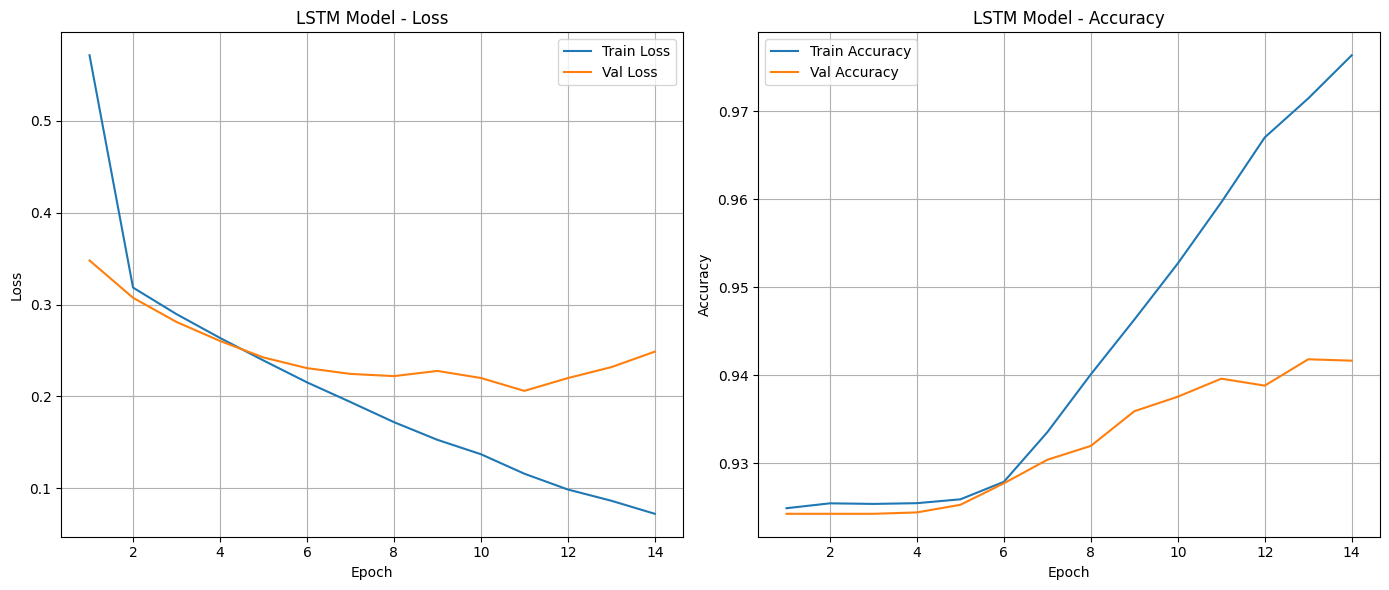

In [120]:
# Plotting training and validation loss/accuracy for LSTM model

epochs = range(1, len(train_losses_rnn) + 1)

plt.figure(figsize=(14, 6))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_rnn, label='Train Loss')
plt.plot(epochs, val_losses_rnn, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model - Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_rnn, label='Train Accuracy')
plt.plot(epochs, val_accuracies_rnn, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model - Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [121]:
class PositionalEncoding(nn.Module):
    """
    Implements the sinusoidal positional encoding for transformer models.
    Adds fixed position-dependent information to input embeddings.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Args:
            d_model (int): Dimension of embedding vectors.
            dropout (float): Dropout rate applied after adding positional encoding.
            max_len (int): Maximum sequence length supported.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix of [max_len, d_model] to store position encodings
        pe = torch.zeros(max_len, d_model)

        # Position indices: shape [max_len, 1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Compute the divisor term for the sinusoidal function
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sin to even indices in the embedding dimension 
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cos to odd indices in the embedding dimensions
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension: [1, max_len, d_model]
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]

        # Register as buffer to prevent updates during training
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encoding to input tensor.

        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len, d_model]

        Returns:
            Tensor: Encoded tensor with the same shape as input.
        """
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [15]:
class TransformerforNER(nn.Module):
    """
    Transformer-based model for Named Entity Recognition (NER).
    Applies a stack of Transformer encoder layers to predict token-level NER tags.
    """
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, num_heads=4, hidden_dim=256, num_layers=2, dropout=0.1, max_len=50):
        """
        Args:
            vocab_size (int): Size of the input vocabulary.
            tagset_size (int): Number of NER tags (output classes).
            embedding_dim (int): Dimension of word embeddings.
            num_heads (int): Number of attention heads in the Transformer.
            hidden_dim (int): Dimension of the feedforward network in the encoder.
            num_layers (int): Number of encoder layers.
            dropout (float): Dropout rate.
            max_len (int): Maximum input sequence length for positional encoding.
        """
        super(TransformerforNER, self).__init__()

        # Word embedding layer with padding index
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx["<PAD>"])
        
        # Add sinusoidal positional encoding to preserve sequence information
        self.positional_encoding = PositionalEncoding(embedding_dim, dropout, max_len)
        
        # Define a single Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True  # Maintain [batch_size, seq_len, embed_dim] shape
        )

        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final linear layers to protect encoded features to tagset size
        self.fc = nn.Linear(embedding_dim, tagset_size)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len]

        Returns:
            Tensor: Output tensor of shape [batch_size, seq_len, tagset_size]
        """
        embedded = self.embedding(x)                # [batch_size, seq_len, embedding_dim]
        encoded = self.positional_encoding(embedded) 
        transformer_out = self.transformer_encoder(encoded) # [batch_size, seq_len, embedding_dim]
        output = self.fc(transformer_out)             # [batch_size, seq_len, tagset_size]
        return output

In [98]:
# Transformer Training Configuration

# Early stopping setup
best_val_loss = float('inf')
patience = 3
counter = 0

# Training epochs
num_epochs = 50  # Allow sufficient epochs: early stopping will terminate if no improvement

# Instantiate the Transformer model
transformer_model = TransformerforNER(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_dim=100,
    num_heads=4,
    hidden_dim=256,
    num_layers=2,
    dropout=0.1,
    max_len=50
).to(device)

# Define loss and optimizer
criterion_transformer = nn.CrossEntropyLoss()
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Lists to track loss and accuracy over epochs
train_losses_transformer = []
val_losses_transformer = []
train_accuracies_transformer = []
val_accuracies_transformer = []

# Training loop
for epoch in range(num_epochs):
    transformer_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_transformer.zero_grad()
        outputs = transformer_model(inputs) # [batch_size, seq_len, tagset_size]

        # Reshape for loss computation
        outputs = outputs.view(-1, outputs.shape[-1]) # [batch_size * seq_len, tagset_size]
        labels = labels.view(-1) # [batch_size * seq_len]

        loss = criterion_transformer(outputs, labels)
        loss.backward()
        optimizer_transformer.step()

        running_loss += loss.item()

        # Accuracy calculation (excluding PAD tokens)
        preds = outputs.argmax(dim=1)
        mask = (labels != 390) # Ignore <PAD> token (index 390)
        correct += ((preds == labels) & mask).sum().item()
        total += mask.sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    # Validation loop
    transformer_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = transformer_model(inputs)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            loss = criterion_transformer(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            mask = (labels != 390)
            val_correct += ((preds == labels) & mask).sum().item()
            val_total += mask.sum().item()

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total

    # Store metics
    train_losses_transformer.append(epoch_loss)
    val_losses_transformer.append(val_epoch_loss)
    train_accuracies_transformer.append(epoch_acc)
    val_accuracies_transformer.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # ===== Early Stopping + Checkpoint =====
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_transformer = copy.deepcopy(transformer_model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Load the best-performing model
transformer_model.load_state_dict(best_model_transformer)

Epoch [1/50] Train Loss: 0.3678, Train Acc: 0.9061 Val Loss: 0.3006, Val Acc: 0.9243
Epoch [2/50] Train Loss: 0.2922, Train Acc: 0.9255 Val Loss: 0.2812, Val Acc: 0.9243
Epoch [3/50] Train Loss: 0.2751, Train Acc: 0.9254 Val Loss: 0.2763, Val Acc: 0.9250
Epoch [4/50] Train Loss: 0.2504, Train Acc: 0.9261 Val Loss: 0.2522, Val Acc: 0.9270
Epoch [5/50] Train Loss: 0.2404, Train Acc: 0.9284 Val Loss: 0.2447, Val Acc: 0.9282
Epoch [6/50] Train Loss: 0.2166, Train Acc: 0.9317 Val Loss: 0.2284, Val Acc: 0.9321
Epoch [7/50] Train Loss: 0.1938, Train Acc: 0.9384 Val Loss: 0.2127, Val Acc: 0.9348
Epoch [8/50] Train Loss: 0.1739, Train Acc: 0.9454 Val Loss: 0.2091, Val Acc: 0.9321
Epoch [9/50] Train Loss: 0.1546, Train Acc: 0.9493 Val Loss: 0.2038, Val Acc: 0.9367
Epoch [10/50] Train Loss: 0.1352, Train Acc: 0.9563 Val Loss: 0.2036, Val Acc: 0.9357
Epoch [11/50] Train Loss: 0.1198, Train Acc: 0.9610 Val Loss: 0.2171, Val Acc: 0.9324
Epoch [12/50] Train Loss: 0.1086, Train Acc: 0.9640 Val Loss: 0

<All keys matched successfully>

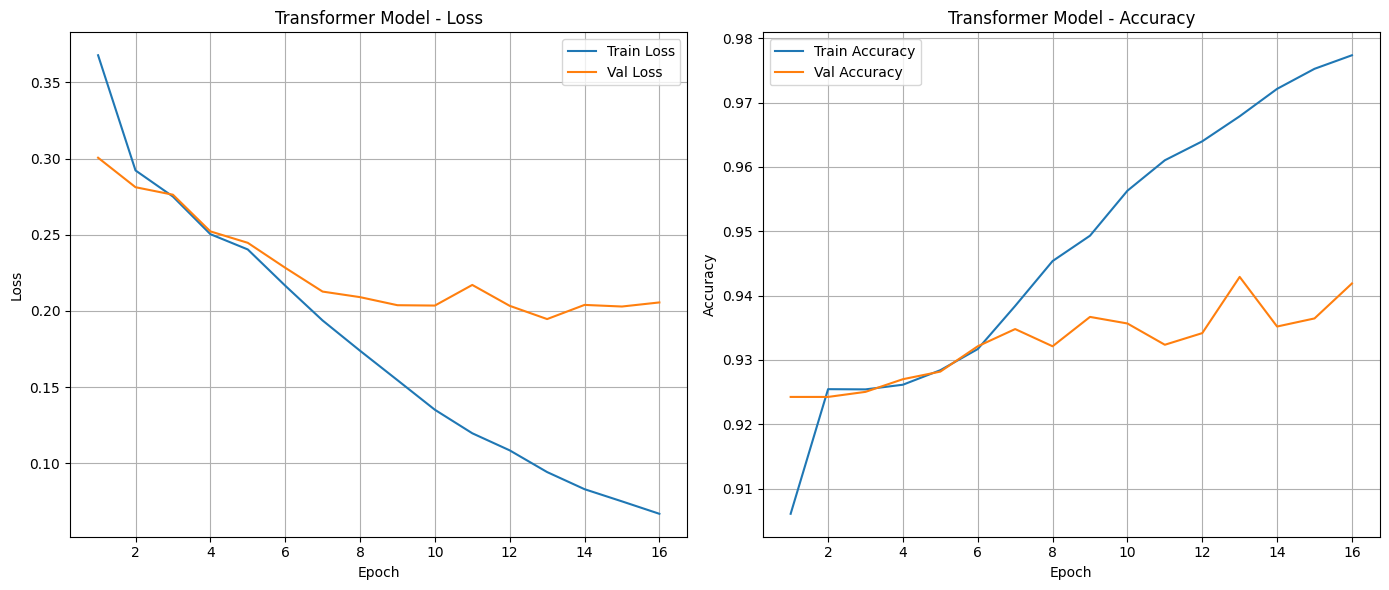

In [123]:
# Plotting training and validation loss/accuracy for Transformer model

epochs = range(1, len(train_losses_transformer) + 1)

plt.figure(figsize=(14, 6))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_transformer, label='Train Loss')
plt.plot(epochs, val_losses_transformer, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transformer Model - Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_transformer, label='Train Accuracy')
plt.plot(epochs, val_accuracies_transformer, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transformer Model - Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).



== LSTM Test Evaluation ==
Test Loss: 0.2112, Test Accuracy: 0.9355

Classification Report:
              precision    recall  f1-score   support

       I-LOC       0.44      0.22      0.30       198
      I-MISC       0.00      0.00      0.00       207
       I-ORG       0.41      0.35      0.38       267
       I-PER       0.58      0.13      0.21       246
           O       0.95      0.99      0.97     11832

    accuracy                           0.94     12750
   macro avg       0.48      0.34      0.37     12750
weighted avg       0.91      0.94      0.92     12750



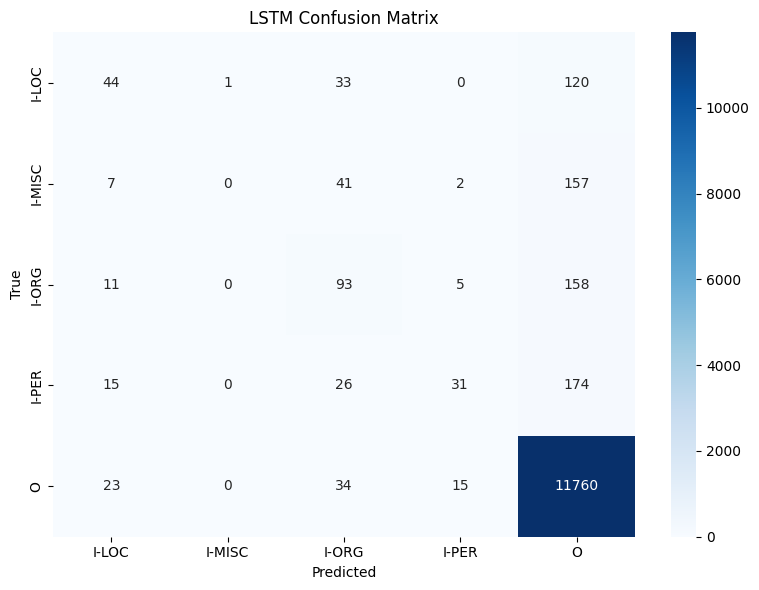


== Transformer Test Evaluation ==
Test Loss: 0.2082, Test Accuracy: 0.9415

Classification Report:
              precision    recall  f1-score   support

       I-LOC       0.57      0.47      0.51       198
      I-MISC       0.50      0.30      0.38       207
       I-ORG       0.36      0.35      0.35       267
       I-PER       0.81      0.29      0.43       246
           O       0.96      0.99      0.98     11832

    accuracy                           0.94     12750
   macro avg       0.64      0.48      0.53     12750
weighted avg       0.94      0.94      0.94     12750



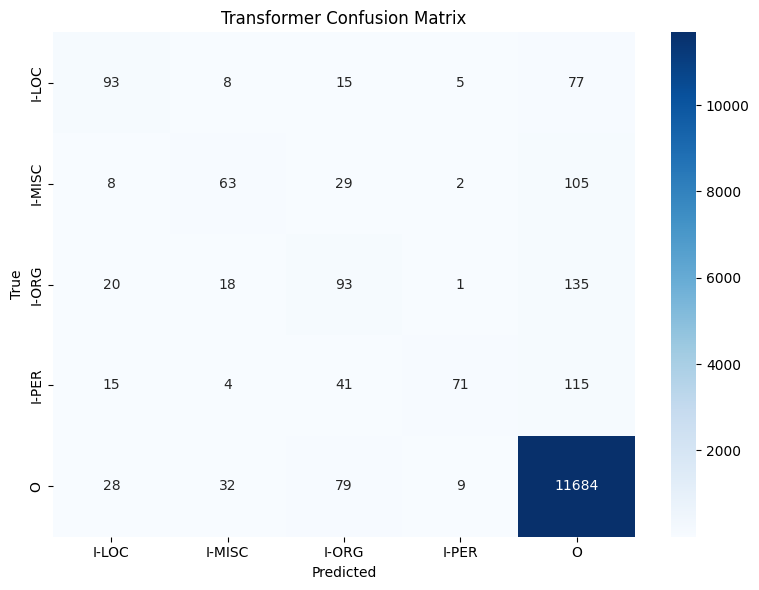

In [104]:
# Model Evaluation Function
def evaluate_model(model, test_loader, name="Model"):
    """
    Evaluate the given NER model on the test dataset.

    Args:
        model (nn.Module): Trained PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader containing test data.
        name (str): Optional name for the model (used in print statements).

    Prints:
        - Test Loss
        - Test accuracy (excluding PAD tokens)
        - Classification report (precisioni, recall, f1-score)
        - Confusion matrix heatmap
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1, outputs.shape[-1]) # [batch_size * seq_len, tagset_size]
            labels = labels.view(-1) # [batch_size * seq_len]

            loss = criterion_rnn(outputs, labels) # Using same loss function for both models
            test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            mask = (labels != 390) # Exclude <PAD> token (index 390)
            correct += ((preds == labels) & mask).sum().item()
            total += mask.sum().item()

            # Store predictions and true labels for reporting
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())

    # Compute average test loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    
    # Print performance summary
    print(f"\n== {name} Test Evaluation ==")
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}\n")

    # Classification report (per class precision, recall, f1-score)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[idx2tag[i] for i in range(len(tag2idx)) if i != 390]))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=[idx2tag[i] for i in range(len(tag2idx)) if i != 390], yticklabels=[idx2tag[i] for i in range(len(tag2idx)) if i != 390], cmap="Blues")

    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Run evaluation on both models
evaluate_model(rnn_model, test_loader, name='LSTM')
evaluate_model(transformer_model, test_loader, name='Transformer')